# Cosmetics Company KPI — Synthetic Dataset & Analysis

This notebook generates a realistic synthetic weekly dataset for a cosmetics company (10 products, 2 years), computes KPIs, performs analyses and produces visualizations. It is suitable for a portfolio sample project.

**What's included**:
- Data generation (weekly rows per product)
- KPI calculations: Rolling, MoM, YoY, Efficiency, Defect Rate, Profit Margin
- Aggregations: monthly & yearly
- Visualizations: time series, bar charts, scatter + regression, correlation heatmap, waterfall, Pareto, simple forecast
- Exports: CSV dataset saved to `cosmetics_kpi_dataset.csv`

> Note: This notebook uses `matplotlib` (no seaborn). Each chart is in its own figure.


In [4]:
# @author: ALI GHANBARI 
# @email: alighanbari446@gmail.com

# Cell: imports & setup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import os

pd.options.mode.chained_assignment = None
np.random.seed(42)

# Parameters
start_date = "2023-01-01"
end_date = "2024-12-31"
freq = "W-MON"  # weekly data (each Monday)
dates = pd.date_range(start=start_date, end=end_date, freq=freq)

n_products = 10
product_categories = ["Skincare", "Makeup", "Haircare", "Fragrance"]
products = []
for i in range(n_products):
    cat = np.random.choice(product_categories, p=[0.4,0.3,0.2,0.1])
    name = f"{cat[:3].upper()}_SKU_{i+1:02d}"
    products.append({"Product_ID": f"P{i+1:03d}", "Product_Name": name, "Category": cat})

products_df = pd.DataFrame(products)

# Create weekly rows per product
rows = []
for _, p in products_df.iterrows():
    base_demand = np.random.randint(500, 2000)  # baseline weekly demand units
    base_price = np.round(np.random.uniform(5.0, 45.0), 2)  # price per unit
    base_cost = np.round(base_price * np.random.uniform(0.35, 0.65), 2)  # cost per unit
    material_per_unit = np.round(np.random.uniform(0.05, 0.5), 3)  # kg of raw material per unit
    for d in dates:
        week_index = (d - pd.to_datetime(start_date)).days // 7
        month = d.month
        season_factor = 1.0 + (0.15 if month in [11,12] else 0.05 if month in [4,5] else 0.0)
        trend = 1.0 + (week_index * np.random.normal(0.0008, 0.0005))
        noise = np.random.normal(1.0, 0.12)
        produced_units = max(0, int(base_demand * season_factor * trend * noise))
        downtime_hours = max(0, np.random.normal(5, 2))
        machine_capacity_hours = 7*24*0.2
        efficiency = produced_units / (machine_capacity_hours - downtime_hours + 1e-6)
        defect_rate = np.clip(np.random.normal(0.02, 0.015), 0.0, 0.2)
        good_units = int(produced_units * (1 - defect_rate))
        sales_units = int(good_units * np.random.uniform(0.85, 0.995))
        lead_time = max(1, int(np.random.normal(7, 3) + (0.5 if month in [11,12] else 0)))
        returns_rate = np.clip(np.random.normal(0.02, 0.01), 0.0, 0.15)
        returned_units = int(sales_units * returns_rate)
        price = base_price * np.random.uniform(0.95, 1.10)
        cost = base_cost * np.random.uniform(0.95, 1.08)
        material_consumed_kg = produced_units * material_per_unit
        revenue = sales_units * price
        cogs = produced_units * cost + material_consumed_kg * 0.2
        expenses = np.random.uniform(0.05, 0.12) * revenue + 500
        profit = revenue - cogs - expenses
        profit_margin = profit / revenue if revenue > 0 else 0.0
        customer_acq = max(0, int(sales_units * np.random.uniform(0.02, 0.08)))
        retention_rate = np.clip(np.random.normal(0.70, 0.06), 0.4, 0.95)
        nps = np.clip(np.random.normal(30, 12), -100, 100)
        employee_satisfaction = np.clip(np.random.normal(7.2, 0.9), 1, 10)
        rows.append({
            "Date": d,
            "Product_ID": p["Product_ID"],
            "Product_Name": p["Product_Name"],
            "Category": p["Category"],
            "Produced_Units": produced_units,
            "Good_Units": good_units,
            "Sales_Units": sales_units,
            "Returned_Units": returned_units,
            "Price_per_Unit": round(price,2),
            "Cost_per_Unit": round(cost,2),
            "Material_kg": round(material_consumed_kg,3),
            "Revenue": round(revenue,2),
            "COGS": round(cogs,2),
            "Expenses": round(expenses,2),
            "Profit": round(profit,2),
            "Profit_Margin": round(profit_margin,4),
            "Lead_Time_days": lead_time,
            "Downtime_hours": round(downtime_hours,2),
            "Efficiency_units_per_hour": round(efficiency,2),
            "Defect_Rate": round(defect_rate,4),
            "Returns_Rate": round(returns_rate,4),
            "Customer_Acquisition": customer_acq,
            "Retention_Rate": round(retention_rate,4),
            "NPS": round(nps,1),
            "Employee_Satisfaction": round(employee_satisfaction,2),
            "Week_Index": week_index
        })

df = pd.DataFrame(rows)
df.sort_values(["Product_ID","Date"], inplace=True)
df.reset_index(drop=True, inplace=True)

# Compute additional KPIs and aggregations
targets = []
for pid in df["Product_ID"].unique():
    product_slice = df[df["Product_ID"]==pid]
    baseline = product_slice["Sales_Units"].mean()
    targets.append({"Product_ID": pid, "Weekly_Target": int(baseline * 1.05)})

targets_df = pd.DataFrame(targets)
df = df.merge(targets_df, on="Product_ID", how="left")
df["Target_Achieved"] = df["Sales_Units"] / df["Weekly_Target"]

df["Rolling_4w_Sales"] = df.groupby("Product_ID")["Sales_Units"].transform(lambda x: x.rolling(4, min_periods=1).mean())
df["YoY_Sales_pct"] = df.groupby("Product_ID")["Sales_Units"].transform(lambda x: x.pct_change(52))
df["MoM_Sales_pct"] = df.groupby("Product_ID")["Sales_Units"].transform(lambda x: x.pct_change(4))
df["Rolling_4w_Eff"] = df.groupby("Product_ID")["Efficiency_units_per_hour"].transform(lambda x: x.rolling(4, min_periods=1).mean())

df["Month"] = df["Date"].dt.to_period("M").dt.to_timestamp()
df["Year"] = df["Date"].dt.year

monthly = df.groupby(["Month","Product_ID","Product_Name","Category"]).agg({
    "Produced_Units":"sum","Good_Units":"sum","Sales_Units":"sum","Returned_Units":"sum","Revenue":"sum","COGS":"sum","Expenses":"sum","Profit":"sum","Material_kg":"sum",
    "Customer_Acquisition":"sum","NPS":"mean","Employee_Satisfaction":"mean","Downtime_hours":"sum","Defect_Rate":"mean"
}).reset_index()

yearly = df.groupby(["Year","Product_ID","Product_Name","Category"]).agg({
    "Produced_Units":"sum","Good_Units":"sum","Sales_Units":"sum","Returned_Units":"sum","Revenue":"sum","COGS":"sum","Expenses":"sum","Profit":"sum","Material_kg":"sum",
    "Customer_Acquisition":"sum","NPS":"mean","Employee_Satisfaction":"mean","Downtime_hours":"sum","Defect_Rate":"mean"
}).reset_index()

latest_year = df["Year"].max()
annual_last = yearly[yearly["Year"]==latest_year].copy()
annual_last["Profit_Margin"] = annual_last["Profit"] / annual_last["Revenue"]

# Save dataset
outpath = "cosmetics_kpi_dataset.csv"
df.to_csv(outpath, index=False)
print("Dataset saved to:", outpath)

Dataset saved to: cosmetics_kpi_dataset.csv


## Visualizations

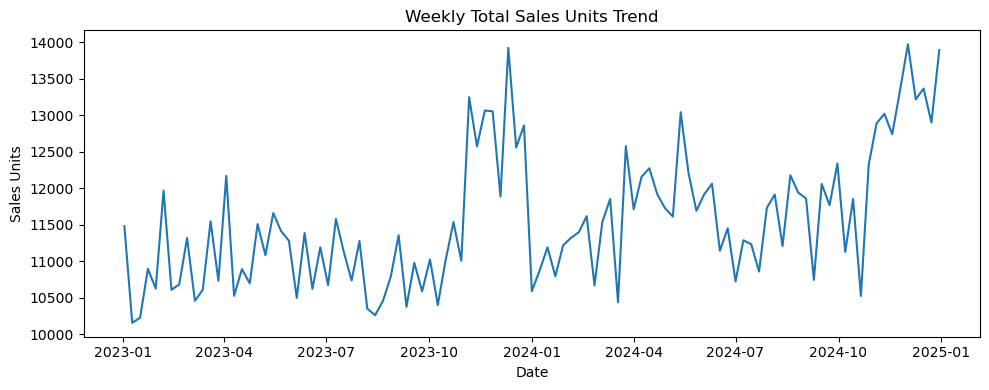

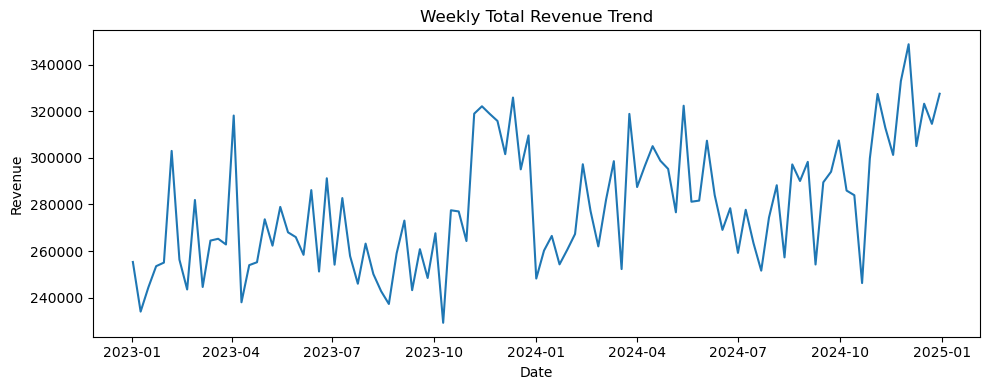

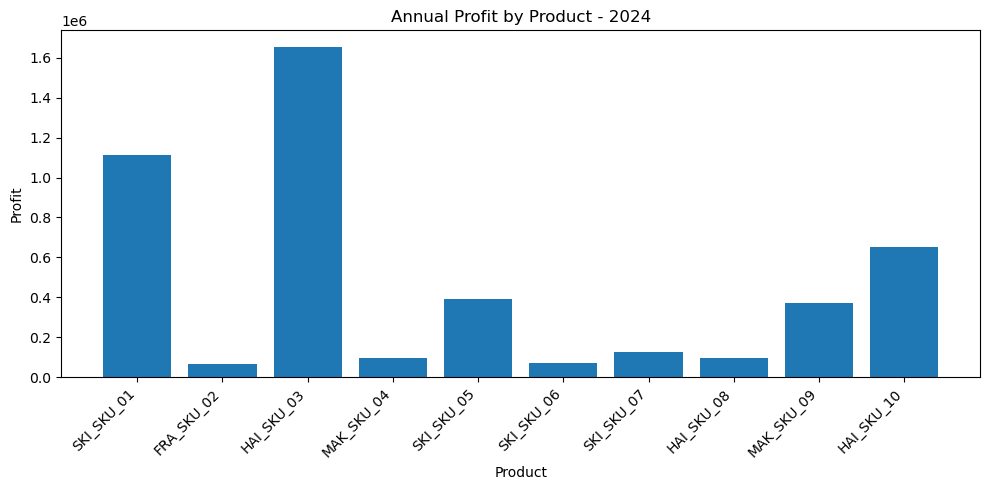

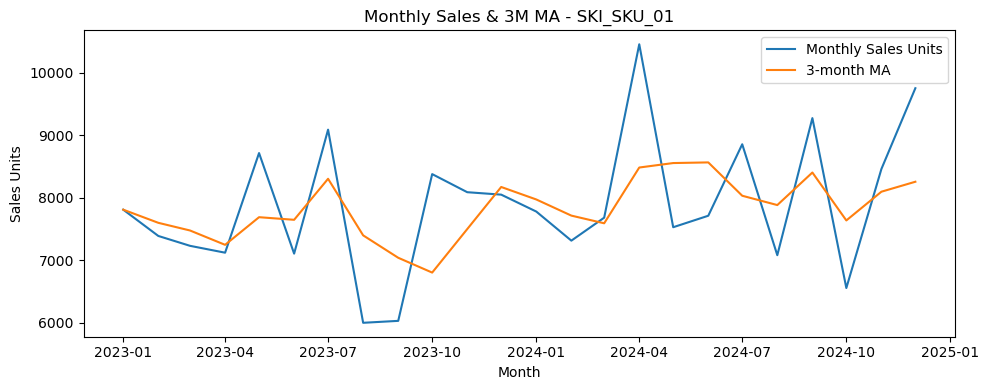

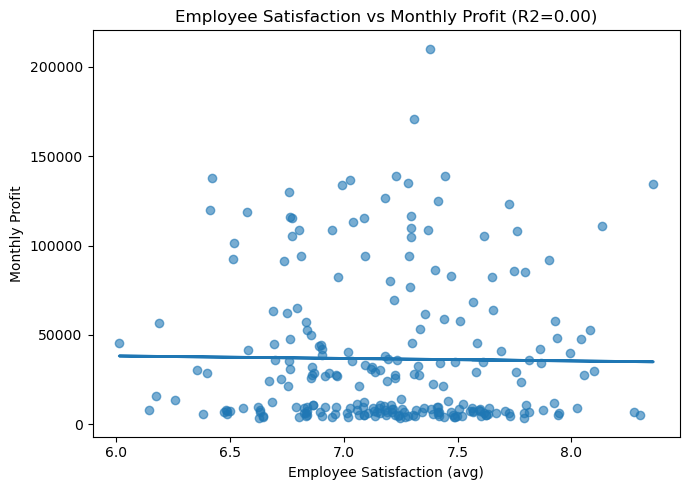

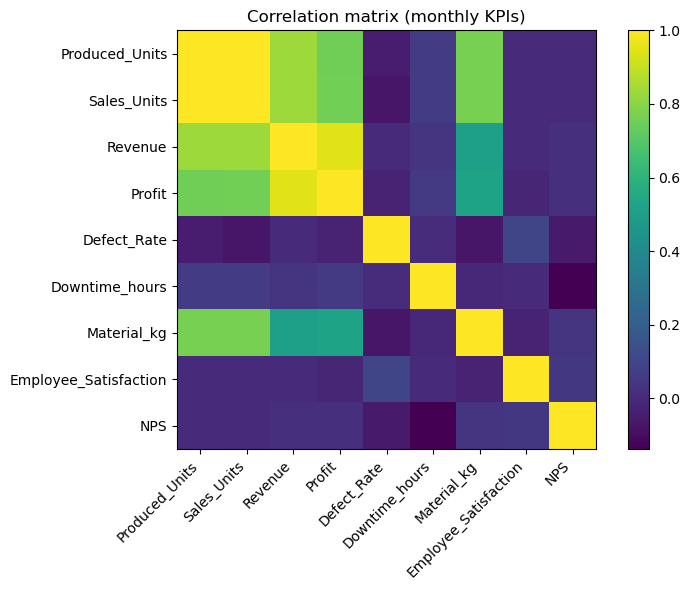

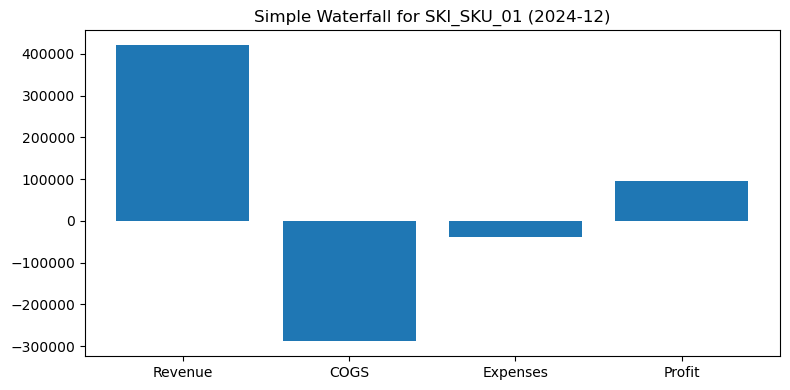

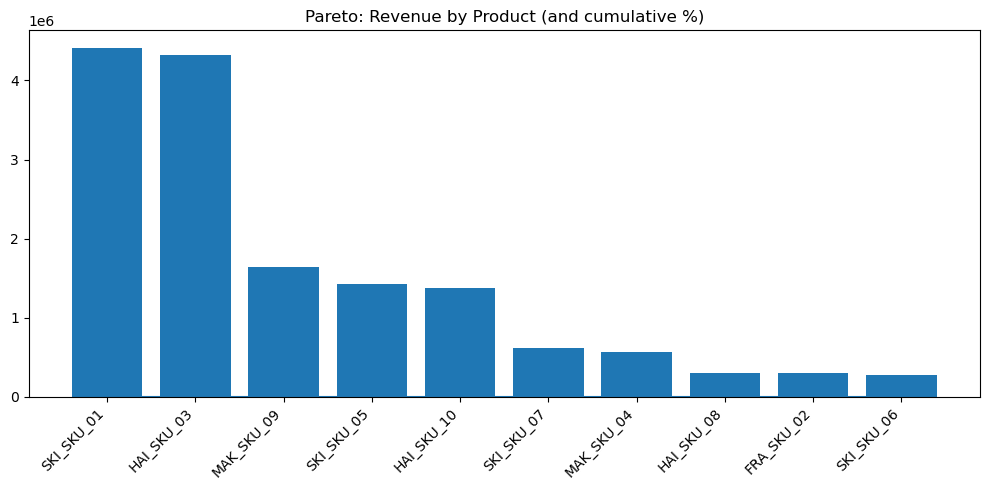

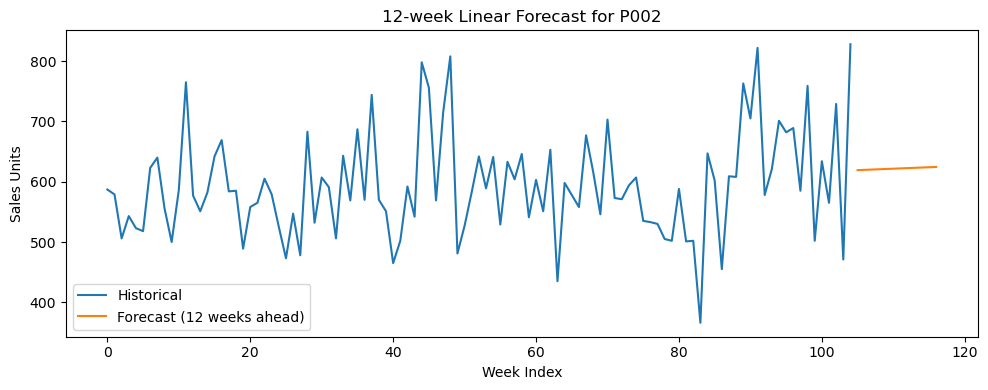

In [5]:
# Cell: Plotting examples (each figure separate)
# 1) Weekly total sales trend
weekly_total = df.groupby("Date")[["Sales_Units","Revenue","Profit"]].sum().reset_index()

plt.figure(figsize=(10,4))
plt.plot(weekly_total["Date"], weekly_total["Sales_Units"])
plt.title("Weekly Total Sales Units Trend")
plt.xlabel("Date")
plt.ylabel("Sales Units")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,4))
plt.plot(weekly_total["Date"], weekly_total["Revenue"])
plt.title("Weekly Total Revenue Trend")
plt.xlabel("Date")
plt.ylabel("Revenue")
plt.tight_layout()
plt.show()

# 2) Annual profit by product
latest_year = df["Year"].max()
annual_last = yearly[yearly["Year"]==latest_year].copy()

plt.figure(figsize=(10,5))
plt.bar(annual_last["Product_Name"], annual_last["Profit"])
plt.title(f"Annual Profit by Product - {latest_year}")
plt.xlabel("Product")
plt.ylabel("Profit")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# 3) MoM growth for a sample product
sample_pid = df["Product_ID"].unique()[0]
sample_monthly = monthly[monthly["Product_ID"]==sample_pid].copy()
sample_monthly.sort_values("Month", inplace=True)

plt.figure(figsize=(10,4))
plt.plot(sample_monthly["Month"], sample_monthly["Sales_Units"], label="Monthly Sales Units")
plt.plot(sample_monthly["Month"], sample_monthly["Sales_Units"].rolling(3, min_periods=1).mean(), label="3-month MA")
plt.title(f"Monthly Sales & 3M MA - {sample_monthly['Product_Name'].iloc[0]}")
plt.xlabel("Month")
plt.ylabel("Sales Units")
plt.legend()
plt.tight_layout()
plt.show()

# 4) Scatter + regression: Employee Satisfaction vs Profit (monthly)
monthly_prod = monthly.copy()
X = monthly_prod[["Employee_Satisfaction"]].values
y = monthly_prod["Profit"].values
model = LinearRegression()
model.fit(X, y)
y_pred = model.predict(X)
r2 = r2_score(y, y_pred)

plt.figure(figsize=(7,5))
plt.scatter(monthly_prod["Employee_Satisfaction"], monthly_prod["Profit"], alpha=0.6)
plt.plot(monthly_prod["Employee_Satisfaction"], y_pred, linewidth=2)
plt.title(f"Employee Satisfaction vs Monthly Profit (R2={r2:.2f})")
plt.xlabel("Employee Satisfaction (avg)")
plt.ylabel("Monthly Profit")
plt.tight_layout()
plt.show()

# 5) Correlation matrix (monthly KPIs)
corr_cols = ["Produced_Units","Sales_Units","Revenue","Profit","Defect_Rate","Downtime_hours","Material_kg","Employee_Satisfaction","NPS"]
corr = monthly_prod[corr_cols].corr()

plt.figure(figsize=(8,6))
plt.imshow(corr)
plt.colorbar()
plt.xticks(range(len(corr_cols)), corr_cols, rotation=45, ha="right")
plt.yticks(range(len(corr_cols)), corr_cols)
plt.title("Correlation matrix (monthly KPIs)")
plt.tight_layout()
plt.show()

# 6) Waterfall-like breakdown for a product (last month)
prod = monthly_prod.groupby("Product_ID").last().reset_index().iloc[0]["Product_ID"]
prod_month = monthly_prod[monthly_prod["Product_ID"]==prod].iloc[-1]
labels = ["Revenue","COGS","Expenses","Profit"]
values = [prod_month["Revenue"], -prod_month["COGS"], -prod_month["Expenses"], prod_month["Profit"]]

plt.figure(figsize=(8,4))
plt.bar(range(len(values)), values)
plt.xticks(range(len(values)), labels)
plt.title(f"Simple Waterfall for {prod_month['Product_Name']} ({prod_month['Month'].strftime('%Y-%m')})")
plt.tight_layout()
plt.show()

# 7) Pareto by revenue (annual)
top_rev = annual_last.sort_values("Revenue", ascending=False)
top_rev["CumRev"] = top_rev["Revenue"].cumsum()
top_rev["CumPct"] = top_rev["CumRev"] / top_rev["Revenue"].sum()

plt.figure(figsize=(10,5))
plt.bar(top_rev["Product_Name"], top_rev["Revenue"])
plt.plot(top_rev["Product_Name"], top_rev["CumPct"], marker="o")
plt.xticks(rotation=45, ha="right")
plt.title("Pareto: Revenue by Product (and cumulative %)")
plt.tight_layout()
plt.show()

# 8) Simple 12-week linear forecast for a product
pid = df["Product_ID"].unique()[1]
prod_weekly = df[df["Product_ID"]==pid].groupby("Week_Index").agg({"Sales_Units":"sum"}).reset_index()
Xw = prod_weekly[["Week_Index"]].values
yw = prod_weekly["Sales_Units"].values
lr = LinearRegression()
lr.fit(Xw, yw)
future_idx = np.arange(prod_weekly["Week_Index"].max()+1, prod_weekly["Week_Index"].max()+13).reshape(-1,1)
y_future = lr.predict(future_idx)

plt.figure(figsize=(10,4))
plt.plot(prod_weekly["Week_Index"], prod_weekly["Sales_Units"], label="Historical")
plt.plot(future_idx.flatten(), y_future, label="Forecast (12 weeks ahead)")
plt.title(f"12-week Linear Forecast for {pid}")
plt.xlabel("Week Index")
plt.ylabel("Sales Units")
plt.legend()
plt.tight_layout()
plt.show()


## Save outputs

In [6]:
# Cell: Save key outputs and summary tables
# Save sample aggregated outputs for reporting
monthly_out = "cosmetics_monthly_aggregates.csv"
yearly_out = "cosmetics_yearly_aggregates.csv"
annual_out = "cosmetics_annual_last_year.csv"

monthly.to_csv(monthly_out, index=False)
yearly.to_csv(yearly_out, index=False)
annual_last.to_csv(annual_out, index=False)

print("Saved monthly aggregates to:", monthly_out)
print("Saved yearly aggregates to:", yearly_out)
print("Saved annual KPIs to:", annual_out)

Saved monthly aggregates to: cosmetics_monthly_aggregates.csv
Saved yearly aggregates to: cosmetics_yearly_aggregates.csv
Saved annual KPIs to: cosmetics_annual_last_year.csv
